In [1]:
# Item-Item colaborative filtering with Interpolation weight Model
# Project 4
# Author: Sangeon Park
# Team members: Sangeon Park, Yonghwan Kim 

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import csv
import numpy as np
import collections
import copy
import os,sys,humanize,psutil
import matplotlib.pyplot as plt
import random
import itertools
from itertools import combinations

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
iter = 40 # number of iterations
# trainging dataset directory
training_dataset_dir = '/content/drive/MyDrive/training_dataset.csv'

In [5]:
# Collaborative Filtering with Interpolation weight

# pre-compute similarity

# Test dataset without rating
test_dataset_without_rating_dir = '/content/drive/MyDrive/test_dataset_without_ratings.csv'
# ###########################################################################################################
# # Test dataset without rating
# # Data to predict

# test dataset nested dictionary to avoid creating utility matrix
test_dataset_dict = dict()
test_dataset_unique_items = []
test_dataset_users = []
# Open file
with open(test_dataset_without_rating_dir) as tdwr:
    # read as csv
    csv_reader = csv.reader(tdwr, delimiter=',')
    line_count = 0
    for row in csv_reader:
        # header
        if line_count == 0:
            line_count += 1
        # data
        else:
            # if key does not exist
            if not int(row[0]) in test_dataset_dict:
                test_dataset_dict[int(row[0])] = dict()
            # test datset list has unique items
            test_dataset_unique_items.append(int(row[1]))
            # test data set list of users
            test_dataset_users.append(int(row[0]))
            test_dataset_dict[int(row[0])][int(row[1])] = 0
            
            line_count += 1
# number of users in test dataset    
test_dataset_unique_items = list(set(test_dataset_unique_items)) # make it unique
test_dataset_users = list(set(test_dataset_users)) # make it unique

# # ###########################################################################################################
# For training model
# Dictionary of training dataset
training_dataset_dict = dict()
training_dataset_user_x_dict = dict()
training_dataset_unique_items = []
training_dataset_users = []
training_dataset_avgx_dict = dict() # for glabal base line
training_dataset_avgi_dict = dict() # for glabal base line
# Open file
with open(training_dataset_dir) as trdd:
    # read as csv
    csv_reader = csv.reader(trdd, delimiter=',')
    line_count = 0
    for row in csv_reader:
        # header
        if line_count == 0:
            line_count += 1
        # data
        else:
            if not int(row[0]) in training_dataset_dict:
                training_dataset_dict[int(row[0])] = dict()
            if not int(row[1]) in training_dataset_user_x_dict:
                training_dataset_user_x_dict[int(row[1])] = []

            if not int(row[0]) in training_dataset_avgx_dict:
                training_dataset_avgx_dict[int(row[0])] = []
            if not int(row[1]) in training_dataset_avgi_dict:
                training_dataset_avgi_dict[int(row[1])] = []
            # for glabal base line average user x
            training_dataset_avgx_dict[int(row[0])].append(int(row[2]))
            # for glabal base line average item i
            training_dataset_avgi_dict[int(row[1])].append(int(row[2]))

            training_dataset_dict[int(row[0])][int(row[1])] = int(row[2])
            training_dataset_users.append(int(row[0]))
            # training dataset list unique items
            training_dataset_unique_items.append(int(row[1]))
            # training dataset user x dict
            training_dataset_user_x_dict[int(row[1])].append(int(row[0]))
            line_count += 1
# training dataset list unique items
training_dataset_unique_items = list(set(training_dataset_unique_items))
# training dataset user x dict
training_dataset_users = list(set(training_dataset_users))
# all of users
total_user_list = list(set(test_dataset_users + training_dataset_users))

In [6]:
# counting i,j pairs in each user.
# # ###########################################################################################################
test_dataset_user_x_dict = dict()
# Open file
with open(test_dataset_without_rating_dir) as tdwr:
    # read as csv
    csv_reader = csv.reader(tdwr, delimiter=',')
    line_count = 0
    for row in csv_reader:
        # header
        if line_count != 0:
            # if key does not exist
            if not int(row[0]) in test_dataset_user_x_dict:
                test_dataset_user_x_dict[int(row[0])] = []
            test_dataset_user_x_dict[int(row[0])].append(int(row[1]))
        line_count += 1
# # ###########################################################################################################
# For training model
training_dataset_user_x_dict = dict()
# Open file
with open(training_dataset_dir) as trdd:
    # read as csv
    csv_reader = csv.reader(trdd, delimiter=',')
    line_count = 0
    for row in csv_reader:
        # header
        if line_count != 0:
            if not int(row[0]) in training_dataset_user_x_dict:
                training_dataset_user_x_dict[int(row[0])] = []
            training_dataset_user_x_dict[int(row[0])].append(int(row[1]))
        line_count += 1
# # ###########################################################################################################
ij_set = set()
for user, item1 in test_dataset_user_x_dict.items():
    # permut = itertools.combinations(item1, 2)
    for i_item in item1:
        for j_item in training_dataset_user_x_dict[user]:
            comb = (i_item, j_item)
            ij_set.add(comb)

In [7]:
# To find similarity, all you need is all ratings of two movies. So, you can read details of two movies into memory. Storing the entire matrix will use a lot of memory resources.
# pagenation
page_dict = dict()
# similarity double dicitonary
sim_val = dict()

# item i and j pair
for i, j in ij_set:
    if j in sim_val:
        # if opposite case exist, save the opposite case and continue
        if i in sim_val[j]:
            sim_val[i][j] = sim_val[j][i]
            continue
    # sum of ryi * ryj
    sum_ryi_ryj = 0
    # sum of square ryi
    sum_ryi_sq = 0
    # sum of square ryj
    sum_ryj_sq = 0
    # page hit of i
    page_hit_i = 0
    # page hit of j
    page_hit_j = 0

    if not i in sim_val:
        sim_val[i] = dict()
    # if page hit i
    if i in page_dict:
        page_hit_i = 1
    # if page hit j
    if j in page_dict:
        page_hit_j = 1
        
    ryi_ryj_list = []
    ryi_list = []
    ryj_list = []
    # if page hit i and j
    if page_hit_i and page_hit_j:
        sum_ryi_sq = page_dict[i] # page hit, i
        sum_ryj_sq = page_dict[j] # page hit, j
        if sum_ryi_sq == 0.0 or sum_ryj_sq == 0.0: # if any of them is 0, sim is 0
            sim_val[i][j] = 0
            continue
        else:
            for y in total_user_list: # from all user
                if y not in training_dataset_dict:
                    continue
                if i in training_dataset_dict[y] and j in training_dataset_dict[y]:
                    ryi_ryj_list.append(training_dataset_dict[y][i] * training_dataset_dict[y][j])
            sum_ryi_ryj = np.sum(ryi_ryj_list) 
    # if page hit i
    elif page_hit_i and not page_hit_j:
        sum_ryi_sq = page_dict[i]  # page hit, i
        if sum_ryi_sq == 0.0:  # if any of them is 0, sim is 0
            sim_val[i][j] = 0
            continue
        else:
            for y in total_user_list:  # from all user
                if y not in training_dataset_dict:
                    continue
                if j in training_dataset_dict[y]:
                    ryj_list.append(training_dataset_dict[y][j]) 
                if i in training_dataset_dict[y] and j in training_dataset_dict[y]:
                    ryi_ryj_list.append(training_dataset_dict[y][i] * training_dataset_dict[y][j])
            sum_ryi_ryj = np.sum(ryi_ryj_list) 
            sum_ryj_sq = sqrt(np.sum(np.square(ryj_list)))
            page_dict[j] = sum_ryj_sq# save to page
    # if page hit j
    elif page_hit_j and not page_hit_i:
        sum_ryj_sq = page_dict[j] # page hit, j
        if sum_ryj_sq == 0.0:  # if any of them is 0, sim is 0
            sim_val[i][j] = 0
            continue
        else:
            for y in total_user_list: # from all user
                if y not in training_dataset_dict:
                    continue
                if i in training_dataset_dict[y]:
                    ryi_list.append(training_dataset_dict[y][i])
                if i in training_dataset_dict[y] and j in training_dataset_dict[y]:
                    ryi_ryj_list.append(training_dataset_dict[y][i] * training_dataset_dict[y][j])
            sum_ryi_ryj = np.sum(ryi_ryj_list)
            sum_ryi_sq = sqrt(np.sum(np.square(ryi_list)))
            page_dict[i] = sum_ryi_sq# save to page

    elif not page_hit_i and not page_hit_j: # no page hit, cal all
        for y in total_user_list: # from all user
            if y not in training_dataset_dict:
                continue
            if i in training_dataset_dict[y]:
                ryi_list.append(training_dataset_dict[y][i])
            if j in training_dataset_dict[y]:
                ryj_list.append(training_dataset_dict[y][j]) 
            if i in training_dataset_dict[y] and j in training_dataset_dict[y]:
                ryi_ryj_list.append(training_dataset_dict[y][i] * training_dataset_dict[y][j])        
        sum_ryi_ryj = np.sum(ryi_ryj_list)
        sum_ryi_sq = sqrt(np.sum(np.square(ryi_list)))
        sum_ryj_sq = sqrt(np.sum(np.square(ryj_list)))
        page_dict[i] = sum_ryi_sq # save to page
        page_dict[j] = sum_ryj_sq # save to page
    # if any component is 0, sim is 0
    if sum_ryi_ryj == 0.0 or sum_ryi_sq == 0.0 or sum_ryj_sq == 0.0:
        sim_val[i][j] = 0
    else:
        sim_val[i][j] = sum_ryi_ryj / (sum_ryi_sq * sum_ryj_sq)

In [8]:
# mu: overall mean movie rating
baseline_mu_list = []
# collect baseline mu list
for k1, v1 in training_dataset_dict.items():
    baseline_mu_list = baseline_mu_list + list(v1.values())

sum_baseline_mu = sum(baseline_mu_list)
# baseline mu value
baseline_mu = sum_baseline_mu/len(baseline_mu_list)

# pre calculate bxi
# j list
bxi_dict = dict() # bxi [user][item i]
r_st_x_dict = dict()
bxj_dict = dict() # bxj [user][item j]
sim_j_dict = dict() # list of sim(i,j)
set_of_all_js = set()

for k1, v1 in test_dataset_dict.items(): # user k1
    if k1 not in bxi_dict:
        bxi_dict[k1] = dict()
    # r_st_x
    r_st_x = 0
    if k1 in training_dataset_avgx_dict:
        r_st_x = (np.sum(training_dataset_avgx_dict[k1]) / len(training_dataset_avgx_dict[k1])) - baseline_mu
        r_st_x_dict[k1] = r_st_x
    for k2, v2 in v1.items(): # item i k2  
        # r_st_i     
        r_st_i = 0
        if k2 in training_dataset_avgi_dict:  
            r_st_i = (np.sum(training_dataset_avgi_dict[k2]) / len(training_dataset_avgi_dict[k2])) - baseline_mu
        b_x_i = baseline_mu + r_st_x + r_st_i # baseline b_x_i
        # save bxi to dictionary
        bxi_dict[k1][k2] = b_x_i
        # similarlar js that has over 0.5 sim value
        if k2 not in sim_j_dict:
            sim_j_dict[k2] = set()
        for k3, v3 in sim_val[k2].items(): # item j k3
            if v3 >= 0.5: # threshhold
                sim_j_dict[k2].add(k3) # list of j
                set_of_all_js.add(k3)
        # if there is no sim over 0.5
        isEmpty = (len(sim_j_dict[k2]) == 0)

        if isEmpty:
            temp_j = 0
            temp_sim = 0
            # collect the highest sim j 
            for k3, v3 in sim_val[k2].items(): # item j k3
                if temp_sim < v3: # threshhold
                    temp_sim = v3
                    temp_j = k3
            sim_j_dict[k2].add(temp_j)
            if temp_j != 0:
                set_of_all_js.add(temp_j)

In [9]:
# pre calculate bxj  
for k1, v1 in test_dataset_dict.items(): # user k1
    if k1 not in bxj_dict:
        bxj_dict[k1] = dict()
    r_st_x = r_st_x_dict[k1]
    for j_item in set_of_all_js: # item j_item j
        r_st_j = 0
        if k2 in training_dataset_avgi_dict:  
            r_st_j = (np.sum(training_dataset_avgi_dict[j_item]) / len(training_dataset_avgi_dict[j_item])) - baseline_mu
        b_x_j = baseline_mu + r_st_x + r_st_j # baseline b_x_j        
        bxj_dict[k1][j_item] = b_x_j # save bxj to dictionary

In [44]:
# RMSE function
def RMSE(y_actual, y_predicted):
    rms = sqrt(mean_squared_error(y_actual, y_predicted))
    return round(rms,4)

In [45]:
# Test dataset without rating
test_dataset_without_rating_dir = '/content/drive/MyDrive/test_dataset_without_ratings.csv'
test_dataset_dict = dict()
# Open file
with open(test_dataset_without_rating_dir) as tdwr:
    # read as csv
    csv_reader = csv.reader(tdwr, delimiter=',')
    line_count = 0
    for row in csv_reader:
        # header
        if line_count != 0:
            # if key does not exist
            if not int(row[0]) in test_dataset_dict:
                test_dataset_dict[int(row[0])] = dict()
            test_dataset_dict[int(row[0])][int(row[1])] = 0  
        line_count += 1    

# Prediction rating
# weight for plot
j_weight = []
weight_dict = dict()
for r in range(iter): 
    j_weight_list = [] # j weitght list
    rxj_bxj_dict = dict() # rxj - bxj dictionary
    error_i = dict() # error dicitonary

    for k1, v1 in test_dataset_dict.items(): # user k1
        if k1 not in rxj_bxj_dict:
            rxj_bxj_dict[k1] = dict()
        if k1 not in error_i:
            error_i[k1] = dict()

        for k2, v2 in v1.items(): # item i k2
            b_x_i = bxi_dict[k1][k2] # bxi
            r_x_i = v2 # rxi
            if k2 not in weight_dict:
                weight_dict[k2] = dict()
            # wight * (rxj - bxj)
            sum_wrb_list = []
            
            for j in sim_j_dict[k2]:
                # rxj
                r_x_j = 0
                if j in training_dataset_dict[k1]:
                    r_x_j = training_dataset_dict[k1][j]
                if r_x_j == 0:
                    continue
                # bxj
                b_x_j = 0
                if j == 0:
                    b_x_j = baseline_mu + r_st_x_dict[k1]
                elif j != 0:
                    b_x_j = bxj_dict[k1][j]
                # weight dictionary initializing with random float between 0 to 1
                if j not in weight_dict[k2]:
                    weight_dict[k2][j] = random.uniform(0, 1) # random intial weight

                if j not in rxj_bxj_dict[k1]: # k1 user, j item
                    rxj_bxj_dict[k1][j] = r_x_j - b_x_j 
                tempt = weight_dict[k2][j] * (r_x_j - b_x_j)
                sum_wrb_list.append(tempt)
            
            sum_wrb = np.sum(sum_wrb_list)
            # prediction rating (hat_r_x_i)
            hat_r_x_i = b_x_i + sum_wrb
            test_dataset_dict[k1][k2] = hat_r_x_i
            # error ( hat rating - true rating )
            error_rate = hat_r_x_i - r_x_i
            # J(W)
            j_weight_list.append(error_rate**2)

            if k2 not in error_i[k1]:
                error_i[k1][k2] = error_rate
    # weight dictionary
    wij_list = dict()
    for k1, v1 in test_dataset_dict.items(): # user k1
        for k2, v2 in v1.items(): # item i k2
            if k2 not in wij_list:
                wij_list[k2] = dict()
            for k3, v3 in rxj_bxj_dict[k1].items():  # item j
                if k3 not in wij_list[k2]:
                    wij_list[k2][k3] = 0
                wij_list[k2][k3] = wij_list[k2][k3] + (v2*v3) # error * rxj-bxj
    for k1, v1 in weight_dict.items():
        for k2, v2 in v1.items():
            weight_dict[k1][k2] = weight_dict[k1][k2] - (0.0005 * wij_list[k1][k2]) # learning rate 0.0005
                
    j_weight.append(np.sum(j_weight_list)) # w_ij
    # list of prediciton
    list_of_prediction = []
    # list of test dataset with rating
    list_of_realdata = []

    test_dataset_dir = '/content/drive/MyDrive/test_dataset.csv'
    # For rmse accuracy test
    # Open file
    with open(test_dataset_dir) as tdd:
        # read as csv
        csv_reader = csv.reader(tdd, delimiter=',')
        line_count = 0
        for row in csv_reader:
            # header
            if line_count == 0:
                line_count += 1
            # data
            else:
                list_of_realdata.append(int(row[2]))
                list_of_prediction.append(test_dataset_dict[int(row[0])][int(row[1])])
                line_count += 1
    # Calculate RMSE
    it_it_CF_intr_wigt_rmse = RMSE(list_of_realdata, list_of_prediction)
    print(f'Item-Item CF with Interpolation weight Model, RMSE: {it_it_CF_intr_wigt_rmse}') 

Item-Item CF with Interpolation weight Model, RMSE: 2.2608
Item-Item CF with Interpolation weight Model, RMSE: 2.1713
Item-Item CF with Interpolation weight Model, RMSE: 2.0901
Item-Item CF with Interpolation weight Model, RMSE: 2.0166
Item-Item CF with Interpolation weight Model, RMSE: 1.9498
Item-Item CF with Interpolation weight Model, RMSE: 1.8893
Item-Item CF with Interpolation weight Model, RMSE: 1.8343
Item-Item CF with Interpolation weight Model, RMSE: 1.7844
Item-Item CF with Interpolation weight Model, RMSE: 1.739
Item-Item CF with Interpolation weight Model, RMSE: 1.6979
Item-Item CF with Interpolation weight Model, RMSE: 1.6604
Item-Item CF with Interpolation weight Model, RMSE: 1.6265
Item-Item CF with Interpolation weight Model, RMSE: 1.5956
Item-Item CF with Interpolation weight Model, RMSE: 1.5676
Item-Item CF with Interpolation weight Model, RMSE: 1.5421
Item-Item CF with Interpolation weight Model, RMSE: 1.519
Item-Item CF with Interpolation weight Model, RMSE: 1.4981

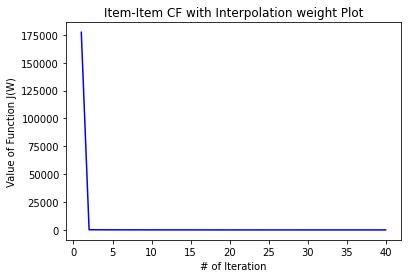

In [46]:
# plot of function JW
t = range(1,iter+1)
# plot with data function JW
plt.plot(t, j_weight, color='b')
# plot title
plt.title("Item-Item CF with Interpolation weight Plot")
# plot y label
plt.ylabel("Value of Function J(W)")
# plot x label
plt.xlabel("# of Iteration")

plt.show()

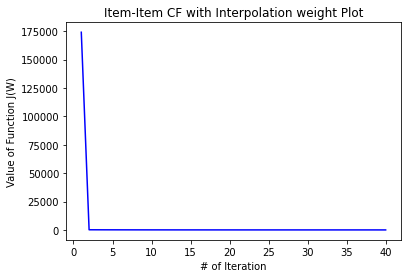